In [47]:
# input 
family_name='FirGroup2Hooklog (old)'
BASE = '03ae42959b733f11a168e268_1264.trace.hooklog'

In [48]:
import os
import itertools
import collections
import time
import shutil
import csv
import pickle
import threading
import matplotlib.pyplot as plt
import multiprocessing
from matplotlib.patches import FancyArrowPatch
import chardet

##初始化
#開啟matplotlib功能
%matplotlib inline

#jupyter擴充功能，可以到https://github.com/ipython-contrib/jupyter_contrib_nbextensions/wiki/Home-4.x-(Jupyter)觀看細節

%run "classes/alignment/OrderedSet.ipynb"
%run "classes/alignment/Alignment.ipynb"

In [49]:
#execution trace相關
def addFeature(api, handle):
    parword = "#PR#"
    retword = "#PR#"
    
    if api not in API:
        print api, "not in API"
        return api
    
    while(1):
        pos = handle.tell()
        line = handle.readline()
        if not line: # reach to the end of file
            return api+parword+retword
        if line[0] == '#': # reach to next call
            handle.seek(pos)
            return api+parword+retword
        
        delimiter = line[1:].find('=') +1 # MIKE: for =Reg
        p = line[:delimiter]
        v = line[delimiter+1:].strip()
        if not isAll:       
            if par == 1 and (p in APIPar1Ret[api][0]):
                parword += parTrans(api, p, v) # v sometimes could be empty!
            if rvalue == 1 and (p in APIPar1Ret[api][1]):
                retword += v
        else:
            if p in ['Return', 'result']:
                retword += v
            else:
                parword = parword + line + '?'          

def parTrans(api, key, value):
    t = api+key
    
    if not trans:
        return value
    
    if t in FuncDict:
        return FuncDict[t](value) # function dictionary
    else:
#         print "no such transformation", api, key
        return value

def libTrans(value):
    DIR = LIB = EXT = ""
    
    # for empty value
    if value == "":
        return "NON@NON@NON"
    
    lvalue = value.lower()
    tokens = lvalue.split('\\')
    
    # DIR
    if lvalue[1] != ':':
        DIR = "SYS"
    elif lvalue[0] == '\\':
        DIR = "LOC"
    else:
        for d in dir_dict:
            if d in lvalue:
                DIR = dir_dict[d]
                break
    
    # EXT
    t = tokens[-1].split('.')
    ext = t[-1]
    if ext == "" or len(t) == 1: # extension is . or no extension
        EXT = "DLL"
    else:
        EXT = ext.upper()
        
    # LIB
    LIB = tokens[-1].split('.')[0].lower()
    
    #return DIR+"@"+LIB+"@"+EXT+"("+value+")"
    return DIR+"@"+LIB+"@"+EXT

def thdTrans(value):
    return "NON"

def fileTrans(value):
    DIR = EXT = ""
    
    # for empty value
    if value == "":
        return "NON@NON"
    
    lvalue = value.lower().replace('/', '\\')
    tokens = lvalue.split('\\')
    
    #DIR
    if lvalue.startswith("\\\\.\\"):
        DIR = "NET"
    elif lvalue[0] == '\\' or len(tokens) == 1:
        DIR = "LOC"
    else:
        for d in dir_dict:
            if d in lvalue:
                DIR = dir_dict[d]
                break
    if DIR == "": DIR = "ARB" # possbily c:
    
    # EXT
    t = tokens[-1].split('.')
    ext = t[-1]
    if ext == "" or len(t) == 1: # extension is . or no extension
        EXT = "NON"
    else:
        EXT = ext.upper()
    
    #return DIR+"@"+FIL+"@"+EXT+"("+value+")"
    return DIR+"@"+EXT

def keyTrans(value):
    HK = KEY = ""
    if value == "": return "NON@NON"
    
    lvalue = value.lower()
    tokens = lvalue.split('\\')
    
    # HK
    if tokens[0] in hkey_dict:
        HK = hkey_dict[tokens[0]]
    else:
        HK = "SUBK"
        
    # KEY
    subkey = lvalue[lvalue.find('\\'):]
    KEY = remove_reg(subkey)
    KEY = remove_fileName(KEY)
    KEY = remove_mshist(KEY)
    KEY = remove_sessioninfo(KEY)
    
    #return HK+"@"+KEY+"("+value+")"
    return HK+"@"+KEY

def execTrans(value):
    return fileTrans(value)

def cmdTrans(value):
    return value

def remove_reg(key):
    rvalue = ""
    tokens = key.split('\\')
    
    for t in tokens:
        if t.count('-') > 3:
            rvalue += "\\REGREG"
        else:
            rvalue += ('\\'+t)
    
    return rvalue

def remove_fileName(key):
    tok = key.split('\\')
    tok = [t for t in tok if t!='']
    for i,t in enumerate(tok):
        if '.' in t and len(t.split('.')) == 2:
            tok[i] = '.'+t.split('.')[1]
    return '\\'.join(tok)

def remove_mshist(key):
    tok = key.split('\\')
    tok = [t for t in tok if t!='']
    for i,t in enumerate(tok):
        if 'mshist' in t:
            tok[i] = 'mshistDate'
    return '\\'.join(tok)  

def remove_sessioninfo(key):
    tok = key.split('\\')
    parse_str = '\\'.join(tok)
    if 'software\\microsoft\\windows\\currentversion\\explorer\\sessioninfo' in parse_str:
        tok = parse_str.split('\\')
        if len(tok) == 7:
            tok[-1] = 'SESSIONID'
    return '\\'.join(tok)

FuncDict = {"LoadLibrarylpFileName": libTrans,
            "CreateProcesslpApplicationName": execTrans,
            "CreateProcessInternallpApplicationName": execTrans,
            "CreateThreaddwThreadId": thdTrans, 
            "WinExecCmdLine": cmdTrans,
            "CopyFilelpExistingFileName": fileTrans,
            "CreateFilehName": fileTrans,
            "DeleteFilefileName": fileTrans,
            "RegQueryValuehKey": keyTrans,
            "RegEnumValuehKey": keyTrans,
            "RegOpenKeyhKey": keyTrans,
            "RegCloseKeyhKey": keyTrans,
            "RegSetValuehKey": keyTrans,
            "RegCreateKeyhKey": keyTrans,
            "=RegDeleteKeyhKey": keyTrans, #####
            "RegDeleteKeyhKey": keyTrans,
            "RegDeleteValuehKey": keyTrans
            }

def getNextPair(handle):
    tick = 0
    api = 'api'
    while (1):
        line = handle.readline()
        if not line: break
        if logtype == 'H' and line[0] == '#':
            tick = line[1:].strip()
            api =  handle.readline().strip()
            # MIKE: comment 20150811
            #if par == 1 and (api.startswith('Reg') or api == 'LoadLibrary' or api.startswith('=Reg')):
            #    api += handle.readline().strip()
            # MIKE: 20150811 new for Transformer
            if par == 1 or rvalue == 1:
                api = addFeature(api, handle)
            break
        else:
            continue
    return (tick, api)

def getSortedAPIList(hk):
    hook_list = []
    handle = open(directory_path+hk, 'rb') # MIKE: change mode from 'r' to 'rb', 
    while 1:                               #because windows cannot handel seek() in text(r) mode
        (tick, api) = getNextPair(handle)
        if tick == 0: break
        hook_list.append((tick, api))
    if logtype == 'H':
        hook_list.sort(key=lambda tup: tup[0])
    handle.close()
    
    return hook_list


In [50]:
##==========Parameters begin==========#
#baseline (string): md5_pid
# BASE = '1e662953f0fcd1c62c50b130_1612.trace.hooklog'
#key (string): md5_pid 
#value (list): list of apis with parameters and return
executionTrace = {}
#key (string): md5_pid
#value (list): list of apis with one most significant parameters and return 
featureProfile = {}
alignment = {}

#最後產出的結構們
matchMatrix = {}
gapSeqList = {}
stageMatrix = {}

#stageMatrix的附屬結構，記錄每一個feature profile的motif所對應的原始index
stageMatrixIndex = {}


#key (string): motif id
#value (list): list of winnowed apis with parameter and retrun
motif = {}
#(list): sorted stage index that is common stage 
commonStage = []


#trace.hooklog 的存放位置
family_path='data/family/'+ family_name                         #==========
directory_path = family_path +'/hooklogs/' #==========
#alignment很慢，所以先align並存放在pickle檔中，path指定其位置
aligndata_path = family_path +'/'+family_name+'_fir1000_old.p' #==========
#svg檔輸出位置
svgoutput_path = family_path +'/'+family_name+'_output.svg' #==========
#pdf檔輸出位置
pdfoutput_path = family_path +'/'+family_name+'_output.pdf' #==========
#dot檔輸出位置
dotoutput_path = family_path +'/'+family_name+'_output.dot' #==========
#csv檔輸出位置
stageMotiCsv_path = family_path +'/'+family_name+'_stageMoti.csv' #==========
totalRes_path = family_path +'/'+family_name+'_totalRes.csv' #==========
#malware behavior overview圖輸出位置
stageprofile_path = family_path +'/'+family_name+'_Stage - feature profile plot(high).png' #==========
motifLenfile_path = family_path +'/'+family_name+'_Motif length - probability CDF graph.png'
stageDisMoti_path = family_path +'/'+family_name+"_Stage - distinct motif # graph.png"
#malware final common motif in someFamily
finalComMotif_path = family_path + '/'+family_name+'_final common motif/' #==========
if not os.path.isdir(finalComMotif_path): #==========
    os.makedirs(finalComMotif_path)       #==========
    print "create: ", finalComMotif_path  #==========

#alignment related
par = 1
window = 1
offset = 0
rvalue = 1
trans = 1
encode = 0
isAll = 0

#alignment分數設定
dp_matched = 2
dp_mismatched = -1
dp_gap = -3


logtype = type = 'H' # MIKE: do not use type anymore
del type


#winnow related
APIPar1Ret = {"LoadLibrary": [["lpFileName"], ["Return","result"]],
              #"CreateProcess": [["lpApplicationName","lpCommandLine"], ["Return","result"]],
              "CreateProcess": [["lpApplicationName"], ["Return","result"]],
              #"CreateProcessInternal": [["lpApplicationName","lpCommandLine"], ["Return","result"]],
              "CreateProcessInternal": [["lpApplicationName"], ["Return","result"]],
              "OpenProcess": [[], ["Return","result"]], # it has procName, but might be empty
              "ExitProcess": [[], ["Return","result"]],
              "TerminateProcess": [[], ["Return","result"]],
              "WinExec": [["CmdLine"], ["Return","result"]],
              "CreateRemoteThread": [[], ["Return","result"]], # it has procName, but might be empty
              "OpenThread": [["dwThreadId"], ["Return","result"]],
              "CreateThread": [["dwThreadId"], ["Return","result"]],
              "TerminateThread": [["hThread"], ["Return","result"]],
              "CopyFile": [["lpExistingFileName"], ["Return","result"]], # include lpNewFileName?
              "CreateFile": [["hName"], ["Return","result"]], #MIKE: actually it is 'lpFileName' in spec.
              "WriteFile": [[], ["Return","result"]],
              "ReadFile": [[], ["Return","result"]],
              "DeleteFile": [["fileName"], ["Return","result"]], #MIKE: actually it is 'lpFileName' in spec.
              "CloseHandle": [[], ["Return","result"]],
              "RegOpenCurrentUser": [[], ["Return","result"]],
              "RegQueryValue": [["hKey"], ["Return","result"]],
              "RegEnumValue": [["hKey"], ["Return","result"]],
              "RegOpenKey": [["hKey"], ["Return","result"]],
              "RegCloseKey": [["hKey"], ["Return","result"]],
              "RegSetValue": [["hKey"], ["Return","result"]],
              "RegCreateKey": [["hKey"], ["Return","result"]],
              "=RegDeleteKey": [["hKey"], ["Return","result"]], # MIKE: misprint the '=' #============
              "RegDeleteKey": [["hKey"], ["Return","result"]], # MIKE: misprint the '='
              "RegDeleteValue": [["hKey"], ["Return","result"]],
              "WinHttpConnect": [["pswzServerName"], ["Return","result"]],
              "WinHttpCreateUrl": [["wszUrl"], ["Return","result"]],
              "WinHttpOpen": [["pwszUserAgent"], ["Return","result"]],
              "WinHttpOpenRequest": [["pwszObjectName"], ["Return","result"]],
              "WinHttpReadData": [["lpBuffer"], ["Return","result"]],
              "WinHttpSendRequest": [["pwszHeaders"], ["Return","result"]],
              "WinHttpWriteData": [["lpBuffer"], ["Return","result"]],
              "WinHttpGetProxyForUrl": [["lpcwszUrl"], ["Return","result"]],
              "InternetOpen": [["lpszAgent"], ["Return","result"]],
              "InternetConnect": [["lpszServerName"], ["Return","result"]],
              "HttpSendRequest": [["lpszHeaders"], ["Return","result"]],
              "GetUrlCacheEntryInfo": [["lpszUrlName"], ["Return","result"]],
             }
API = APIPar1Ret.keys() # API list

# It shuld be a precise string for a specific directory, so dont use c:
dir_dict = {"\\windows\\system32\\": "SYS",
            "\\windows\\system\\": "SYS",
            "\\program files\\": "PRO",
            #"\\documents and settings\\all users\\": "USR",
            "\\documents and settings\\": "USR",
            "\\docume~1\\": "USR"
            }

hkey_dict = {"hkey_classes_root": "HKCR",
             "hkey_current_user": "HKCU",
             "hkey_local_machine": "HKLM",
             "hkey_users": "HKUS",
             "hkey_current_config": "HKCC"
             }

threshold = 0.0

##==========Parameters end==========#

In [51]:
#指定BASE與記錄featureProfile於結構中
# BASE = '1e662953f0fcd1c62c50b130_1652.trace.hooklog'

for f in os.listdir(directory_path):
    if f.endswith('.trace.hooklog'):
        featureProfile[f] = [api for tick, api in getSortedAPIList(f)]
# featureProfile

In [52]:
#profile => featureProfile.keys()
#profile_dict => featureProfile
#alignmentList_dict => alignment
#matchMatrix_dict => matchMatrix
#gapSeqList_dict => gapSeqList
#stageMatrix_dict => stageMatrix

print 'total ',len(featureProfile.keys()), 'Execution Traces'

## original version
if not os.path.isfile(aligndata_path): 
    #可以調整processes數量parallel computing
    pool = multiprocessing.Pool(processes=7)
    ali = {}
    for hk in featureProfile.keys():
        ali[hk] = pool.apply_async(pairwise_NW, (BASE, hk, 2, -1, -3, 1, ))
#         print hk, ": ", ali[hk].get()
    pool.close()
    pool.join()
    
    alignment = {}
    for t in ali:
        alignment[t] = ali[t].get()[2]
    pickle.dump(alignment, open(aligndata_path, "wb"))
print 'all pairwise alignment done.'
# print alignment.keys()
# for k in alignment.keys():
#     print len(alignment[k])

total  21 Execution Traces
100 / 1123 finished.
100 / 1188 finished.
100 / 1182 finished.
100 / 1215 finished.
100 / 1219 finished.
100 / 1220 finished.
100 / 1182 finished.
200 / 1188 finished.
200 / 1215 finished.
200 / 1123 finished.
200 / 1219 finished.
200 / 1182 finished.
200 / 1182 finished.
200 / 1220 finished.
300 / 1188 finished.
300 / 1215 finished.
300 / 1182 finished.
300 / 1219 finished.
300 / 1123 finished.
300 / 1182 finished.
300 / 1220 finished.
400 / 1188 finished.
400 / 1182 finished.
400 / 1123 finished.
400 / 1215 finished.
400 / 1219 finished.
400 / 1182 finished.
400 / 1220 finished.
500 / 1188 finished.
500 / 1182 finished.
500 / 1220 finished.
500 / 1123 finished.
500 / 1215 finished.
500 / 1219 finished.
500 / 1182 finished.
600 / 1188 finished.
600 / 1182 finished.
600 / 1220 finished.
600 / 1215 finished.
600 / 1219 finished.
600 / 1123 finished.
600 / 1182 finished.
700 / 1182 finished.
700 / 1188 finished.
700 / 1220 finished.
700 / 1215 finished.
700 / 1

In [53]:
#將alignment結果自路徑中的pickle檔讀取，並存至alignment
alignment = pickle.load(open(aligndata_path,'rb'))

In [54]:
matchMatrix={i+1:[] for i in xrange(len(featureProfile[BASE]))} #index start from 1 to |PB|
gapSeqList={i:[] for i in xrange(len(featureProfile[BASE])+1)} #start is gap, end is not gap
 
for i,k in enumerate(alignment):
    print 'profile', k
    isMeet1 = 0
    if len(featureProfile[k]) > len(featureProfile[BASE]):
        for ii,((i1,t1),(i2,t2)) in enumerate(alignment[k]):
            #判斷是否有在PB[0]之前就插入
            if not isMeet1 and i1 == -1:
                strBuf_list = [t2]
                while alignment[k][ii+1][0][0] == -1:
                    strBuf_list.append(alignment[k][ii+1][1][1])
                    ii += 1
                gapSeqList[0].append((k, strBuf_list))
                isMeet1 = 1
            else:
                isMeet1 = 1
            
            #判斷PB[0]之後的情形
            if t1=='=' and t2!='=' and isMeet1 and alignment[k][ii-1][0][0]!=-1:
                lastIndex = alignment[k][ii-1][0][0]
                strBuf_list = [t2]
                try:
                    while alignment[k][ii+1][0][0] == -1:
                        strBuf_list.append(alignment[k][ii+1][1][1])
                        ii += 1
                except:
                    pass                
                gapSeqList[lastIndex].append((k, strBuf_list))
            elif t2=='=' and t1!='=':
                matchMatrix[i1].append((k,'gap','=')) 
            elif t1!='=' and t2!='=' and t1!=t2:
                matchMatrix[i1].append((k,'mismatch',t2))
            elif t2!='=' and t1!='=' and t1==t2:
                matchMatrix[i1].append((k,'match',t2))
                
    elif len(featureProfile[k]) <= len(featureProfile[BASE]):
        for ii,((i1,t1),(i2,t2)) in enumerate(alignment[k]):
            #判斷是否有在PB[0]之前就插入
            if not isMeet1 and i2 == -1:
                strBuf_list = [t1]
                while alignment[k][ii+1][1][0] == -1:
                    strBuf_list.append(alignment[k][ii+1][0][1])
                    ii += 1
                gapSeqList[0].append((k, strBuf_list))
                isMeet1 = 1
            else:
                isMeet1 = 1
            
            #判斷PB[0]之後的情形
            if t2=='=' and t1!='=' and isMeet1 and alignment[k][ii-1][1][0]!=-1:
                lastIndex = alignment[k][ii-1][1][0]
                strBuf_list = [t1]
                try:
                    while alignment[k][ii+1][1][0] == -1:
                        strBuf_list.append(alignment[k][ii+1][0][1])
                        ii += 1
                except:
                    pass
                gapSeqList[lastIndex].append((k, strBuf_list))
            elif t1=='=' and t2!='=':
                matchMatrix[i2].append((k,'gap','=')) 
            elif t2!='=' and t1!='=' and t1!=t2:
                matchMatrix[i2].append((k,'mismatch',t1))
            elif t2!='=' and t1!='=' and t1==t2:
                matchMatrix[i2].append((k,'match',t1))
# matchMatrix
# gapSeqList

profile f9449d87262a5016f0993d99_1948.trace.hooklog
profile dc6853574777f3bdf6a68c5a_1136.trace.hooklog
profile 681e7884710a3650b7991960_232.trace.hooklog
profile 484818d0428a2303dabdd37b_1024.trace.hooklog
profile e66611da58ad2fcdca426cdb_1860.trace.hooklog
profile 81c2d13624f473c10f9866dee8ce79fb_1468.trace.hooklog
profile 739ab4da384acaeebcba0c66_624.trace.hooklog
profile 79c4772eefb301379a510721_496.trace.hooklog
profile 27546542eea38e818e2ac51d4ec9775f_1440.trace.hooklog
profile 6e68e0ff5efce1297faa3b49_1876.trace.hooklog
profile 03ae42959b733f11a168e268_1264.trace.hooklog
profile 27f348177560314182f161d9ee90b999_1528.trace.hooklog
profile 28e17f1e110f3508ceb611839986a4f4_1396.trace.hooklog
profile 940f7e9ab19be7a9ce0008a6e6b01f9f_s6942.exe_316.trace.hooklog
profile 3002038e55383b4e1d14abc7182a1e78_1364.trace.hooklog
profile e955be2b1ffe866f54d2b261_140.trace.hooklog
profile 90489a23cb732ae082adf3def0b5d243_304.trace.hooklog
profile 2785e2cfe33898e002d3dced37a02375_s4040.exe_932.t

In [55]:
#recheck data in structures are the same
for k in alignment:
    print k, len(getSortedAPIList(k))
    totalLen = 0
    for i in gapSeqList:
        for kin, l in gapSeqList[i]:
            if k == kin:
                totalLen += len(l)
                break
    for i in matchMatrix:
        for kin, stat, api in matchMatrix[i]:
            if k == kin and stat != 'gap':
                totalLen += 1
                break
    print 'totalLen:', totalLen


f9449d87262a5016f0993d99_1948.trace.hooklog 1214
totalLen: 1214
dc6853574777f3bdf6a68c5a_1136.trace.hooklog 1219
totalLen: 1219
681e7884710a3650b7991960_232.trace.hooklog 1215
totalLen: 1215
484818d0428a2303dabdd37b_1024.trace.hooklog 1220
totalLen: 1220
e66611da58ad2fcdca426cdb_1860.trace.hooklog 1215
totalLen: 1215
81c2d13624f473c10f9866dee8ce79fb_1468.trace.hooklog 1182
totalLen: 1182
739ab4da384acaeebcba0c66_624.trace.hooklog 1214
totalLen: 1214
79c4772eefb301379a510721_496.trace.hooklog 1123
totalLen: 1123
27546542eea38e818e2ac51d4ec9775f_1440.trace.hooklog 1182
totalLen: 1182
6e68e0ff5efce1297faa3b49_1876.trace.hooklog 1221
totalLen: 1221
03ae42959b733f11a168e268_1264.trace.hooklog 1225
totalLen: 1225
27f348177560314182f161d9ee90b999_1528.trace.hooklog 1182
totalLen: 1182
28e17f1e110f3508ceb611839986a4f4_1396.trace.hooklog 1182
totalLen: 1182
940f7e9ab19be7a9ce0008a6e6b01f9f_s6942.exe_316.trace.hooklog 1188
totalLen: 1188
3002038e55383b4e1d14abc7182a1e78_1364.trace.hooklog 1182
t

In [56]:
#merge first
stageMatrix = {k:[] for k in featureProfile}
for i,k in enumerate(featureProfile):
    strBuf_list = []
    for ii in range(len(featureProfile[BASE])+1):
        if ii == 0:
            #有在gapSeqList的話就加入，k對應的list，否則加入gap
            if len(gapSeqList[0]) > 0:
                isGap = 1
                for hk, l in gapSeqList[0]:
                    if k == hk:
                        stageMatrix[k].append(l)
                        isGap = 0
                        break
                if isGap:
                    stageMatrix[k].append(['=']) 
        else:
#             if ii==1222: 
#                 print k
#                 print matchMatrix[ii]
            a = [api for hk, stat, api in matchMatrix[ii] if k==hk][0] #！！！！！！！！！！！！！！！！empty
            strBuf_list.append(a)
            
            if len(gapSeqList[ii]) > 0:
                stageMatrix[k].append(strBuf_list)
                strBuf_list = []       
                
                isGap = 1
                for hk, l in gapSeqList[ii]:
                    if k == hk:
                        stageMatrix[k].append(l)
                        isGap = 0
                        break
                if isGap:
                    stageMatrix[k].append(['='])                     
            else:
                if ii <= len(matchMatrix)-1:
                    curColStat_list = [stat for kin, stat, api in matchMatrix[ii]]
                    nextColStat_list = [stat for kin, stat, api in matchMatrix[ii+1]]
                    if curColStat_list != nextColStat_list:
                        stageMatrix[k].append(strBuf_list)
                        strBuf_list = []
                    if curColStat_list == nextColStat_list and ii == len(matchMatrix)-1:
                        stageMatrix[k].append(strBuf_list)

# stageMatrix

In [57]:
#transform multiple gap segment into one gap segment
for i,hk in enumerate(stageMatrix):
    for ii,seg in enumerate(stageMatrix[hk]):
#         print ii
#         print set(seg)
        if set(seg) == set(['=']):
#             print 'bf: ',stageMatrix[hk][ii]
            stageMatrix[hk][ii] = ['=']
#             print 'af: ',stageMatrix[hk][ii]
for i in stageMatrix:
    x =0 
    for t in range(0,len(stageMatrix[i])):
#         print i, t ,len(stageMatrix[i][t])
        x = x + len(stageMatrix[i][t])
    if i ==BASE:
        print 'base--'
    print i,t,x
#     print len(stageMatrix[i])

dc6853574777f3bdf6a68c5a_1136.trace.hooklog 80 1246
681e7884710a3650b7991960_232.trace.hooklog 80 1243
484818d0428a2303dabdd37b_1024.trace.hooklog 80 1246
e66611da58ad2fcdca426cdb_1860.trace.hooklog 80 1243
81c2d13624f473c10f9866dee8ce79fb_1468.trace.hooklog 80 1215
940f7e9ab19be7a9ce0008a6e6b01f9f_s6942.exe_316.trace.hooklog 80 1220
79c4772eefb301379a510721_496.trace.hooklog 80 1141
6e68e0ff5efce1297faa3b49_1876.trace.hooklog 80 1246
61fd4cac9f5429d14d015e7632e3514a_1276.trace.hooklog 80 1223
base--
03ae42959b733f11a168e268_1264.trace.hooklog 80 1249
27f348177560314182f161d9ee90b999_1528.trace.hooklog 80 1215
3002038e55383b4e1d14abc7182a1e78_1364.trace.hooklog 80 1214
28e17f1e110f3508ceb611839986a4f4_1396.trace.hooklog 80 1214
27546542eea38e818e2ac51d4ec9775f_1440.trace.hooklog 80 1214
930bc9f36310286d105c318a96264eba_s1448.exe_772.trace.hooklog 80 1223
e955be2b1ffe866f54d2b261_140.trace.hooklog 80 1246
90489a23cb732ae082adf3def0b5d243_304.trace.hooklog 80 1214
2785e2cfe33898e002d3dce

In [58]:
segment_set = OrderedSet()
for i, segB in enumerate(stageMatrix[BASE]): # for i in range(len(stageMatrix[BASE])) ?
    for hk in stageMatrix:
        segment_set.add(tuple(stageMatrix[hk][i]))
print 'total segment #: ',len(segment_set) 

#apiparam set
apiparam_set = set()
for i,hk in enumerate(stageMatrix): # for hk in stageMatrix ?
    for seg in stageMatrix[hk]:
        for a in seg:
            apiparam_set.add(a)
            
#label each segment
lb2seg_dict=dict()
for i in range(len(segment_set)):
    lb2seg_dict['M'+str(i+1)]= tuple(list(segment_set)[i])
# print lb2seg_dict['M3'] #============
seg2lb_dict=dict()
for k in lb2seg_dict:
    seg2lb_dict[lb2seg_dict[k]] = k
# print seg2lb_dict.keys()[0] #============


total segment #:  76


0 stage
1 stage
2 stage
3 stage
4 stage
5 stage
6 stage
7 stage
8 stage
9 stage
10 stage
11 stage
12 stage
13 stage
14 stage
15 stage
16 stage
17 stage
18 stage
19 stage
20 stage
21 stage
22 stage
23 stage
24 stage
25 stage
26 stage
27 stage
28 stage
29 stage
30 stage
31 stage
32 stage
33 stage
34 stage
35 stage
36 stage
37 stage
38 stage
39 stage
40 stage
41 stage
42 stage
43 stage
44 stage
45 stage
46 stage
47 stage
48 stage
49 stage
50 stage
51 stage
52 stage
53 stage
54 stage
55 stage
56 stage
57 stage
58 stage
59 stage
60 stage
61 stage
62 stage
63 stage
64 stage
65 stage
66 stage
67 stage
68 stage
69 stage
70 stage
71 stage
72 stage
73 stage
74 stage
75 stage
76 stage
77 stage
78 stage
79 stage
80 stage
M3


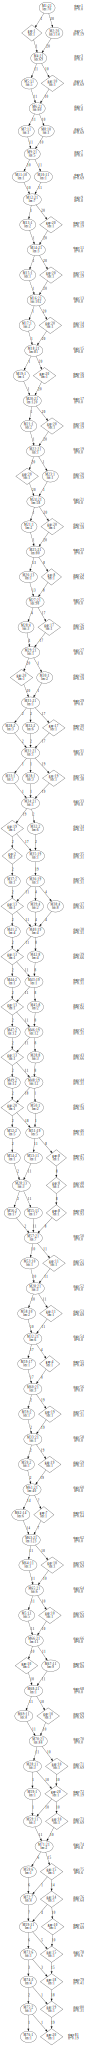

In [59]:
#graph drawing init
import pygraphviz as pgv

g=pgv.AGraph(directed=True)
stage2node_dict = {i:[] for i in range(len(stageMatrix[BASE]))}
stage2Hk_dict = dict() #==========

for i in range(len(stageMatrix[BASE])):
    n_dict = dict()
    for k in stageMatrix:
        lb_key = seg2lb_dict[tuple(stageMatrix[k][i])] #===== lb_keyM1...M8 
        if lb_key not in n_dict.keys():
            n_dict[lb_key] = [k]
        else:
            n_dict[lb_key] = n_dict[lb_key] + [k]
    for lb in n_dict:
        if g.number_of_nodes()==0: #=====len(stageMatrix[n_dict[lb][0]][i]->lb2seg_dict[lb]
            g.add_node(1,label=lb+':'+str(len(n_dict[lb]))+r"\nlen:"+str(len(lb2seg_dict[lb]))
                       ,id=';'.join(n_dict[lb])) 
            stage2node_dict[i]=stage2node_dict[i]+[1] 
        else:
            g.add_node(g.number_of_nodes()+1,label=lb+':'+str(len(n_dict[lb]))+r"\nlen:"+str(len(lb2seg_dict[lb])),
                       id=';'.join(n_dict[lb]))
            stage2node_dict[i]=stage2node_dict[i]+[g.number_of_nodes()]
    stage2Hk_dict[i+1] = n_dict #=======

for k in stage2node_dict:
    print k, 'stage'       
    if k < len(stageMatrix[BASE])-1:
        cur_list = [g.get_node(i) for i in stage2node_dict[k]]
        next_list = [g.get_node(i) for i in stage2node_dict[k+1]]
        for n_cur in cur_list:
            for n_next in next_list:
                for log_cur in n_cur.attr['id'].split(';'):
                    for log_next in n_next.attr['id'].split(';'):
                        if log_cur == log_next:
                            if not g.has_edge(n_cur,n_next):
                                common_set=set(n_cur.attr['id'].split(';')).intersection(
                                    set(n_next.attr['id'].split(';')))
                                g.add_edge(n_cur,n_next,label=len(common_set))

#relabel gap
import re
if tuple(['=']) in seg2lb_dict:
    gap_lb=seg2lb_dict[tuple(['='])]
    for n in g.nodes():
        if n.attr['label'].split(':')[0]==gap_lb:
            tok = re.split('\W+n*',n.attr['label'])
            n.attr['label']='gap'+ ':' + str(tok[1]) + r"\n" + tok[2] + ':' + tok[3]
            n.attr['shape']='diamond'
            n.attr['fillcolor']='yellow'
    print gap_lb
else:
    print 'Warning!'
    for i in range(10):
        print '之後都不用跑了，因為如果沒有gap的話就只有一個stage圖都是多餘的！'

#entropy function
import math
def entropy(l):
    e = 0
    n = sum(list(l))
    for i in l:
        e += float(i)/n*math.log(float(i)/n)
    return abs(e)

#add extra labels (entropy per stage)
last_node = ''
for i in stage2node_dict:
    #stage label and entropy
    g.add_node(len(g.nodes())+1)
    g.get_node(len(g.nodes())).attr['shape'] = 'plaintext'
    n_list = [len(g.get_node(n).attr['id'].split(';')) for n in stage2node_dict[i] if g.get_node(n).attr['id']]
    e = str(round(entropy(n_list), 2))
    g.get_node(len(g.nodes())).attr['label'] = 'stage '+str(i+1)+'\nH='+e
    g.get_node(len(g.nodes())).attr['id'] = 'extra'
    #make them same level
    g.add_subgraph([len(g.nodes())] + [n for n in stage2node_dict[i]], rank='same')
    
stage2common_dict = {l:0 for l in stage2node_dict}
for n in g.nodes():
    if g.get_node(n).attr['label'].startswith('stage'):
        stage = int(g.get_node(n).attr['label'].split()[1]) - 1
        entropy = float(g.get_node(n).attr['label'].split('=')[1]) 
        if entropy <= threshold:
            stage2common_dict[stage] = 1
    
#align stage label
for n in sorted(g.nodes()): 
    if n.attr['id'] == 'extra':
        if int(n) < len(g.nodes())-1:
            g.add_edge(n, int(n)+1, weight=10, style='invis')

from IPython.display import SVG
g.draw(svgoutput_path, format='svg',prog='dot')
g.draw(pdfoutput_path, format='pdf',prog='dot')
g.draw(dotoutput_path, format='dot',prog='dot')

SVG(filename=svgoutput_path)


0.277108433735


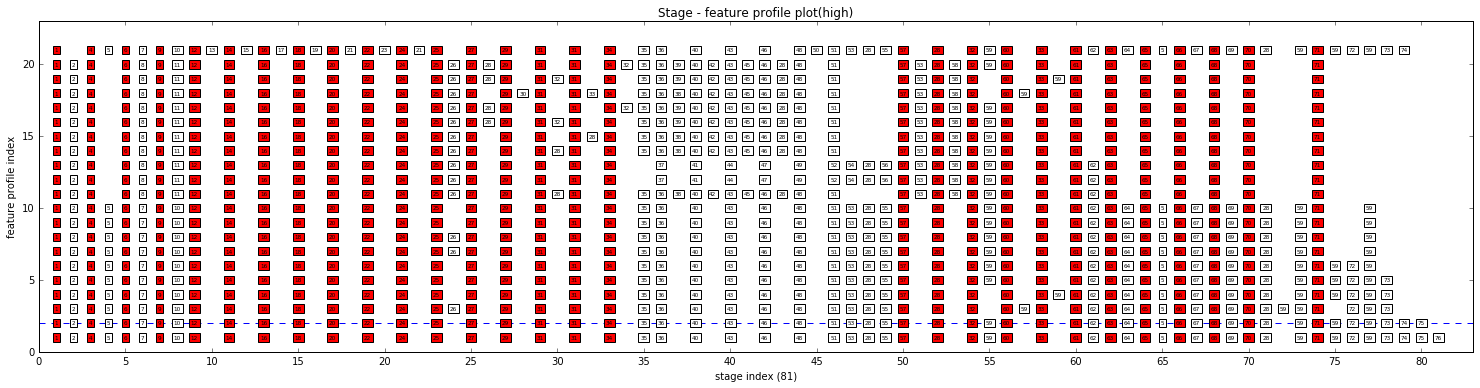

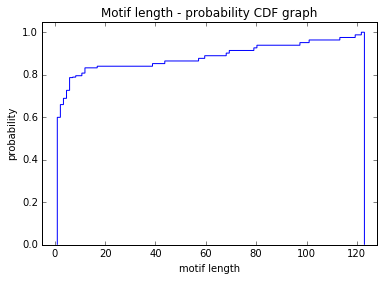

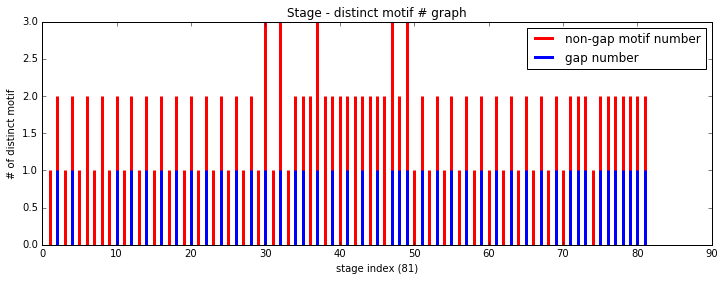

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

#prestruct
max_list=list()
min_list=list()
stagelen_list = list()  #==========
for i in range(len(stageMatrix[BASE])):
    len_list = list()   #==========
    for ii,lg in enumerate(stageMatrix):
        len_list.append(len(stageMatrix[lg][i]))    #==========
        if ii==0:
            maxlen=len(stageMatrix[lg][i])
            minlen=len(stageMatrix[lg][i])
        else:
            if len(stageMatrix[lg][i])>maxlen:
                maxlen=len(stageMatrix[lg][i])
            elif len(stageMatrix[lg][i])<minlen:
                minlen=len(stageMatrix[lg][i])
    max_list.append(maxlen)
    min_list.append(minlen)
    stagelen_list.append(len_list)                  #==========
    
# stagelen_list = list()
# for i in range(len(stageMatrix[BASE])):
#     len_list = list()
#     for ii,lg in enumerate(stageMatrix): 
#         len_list.append(len(stageMatrix[lg][i]))
#     stagelen_list.append(len_list)

#profile每個片段的圖象化
wid = float(len(stageMatrix[BASE])+2)  #==========
hei = float(len(stageMatrix)+2)      #==========
print hei/wid
if hei/wid < 1:
    if hei/wid <0.07:
        fig=plt.figure(num=None, figsize=(24, 24*(hei/wid)*12), dpi=80, facecolor='w', edgecolor='k')
    elif hei/wid <0.15:
        fig=plt.figure(num=None, figsize=(24, 24*(hei/wid)*6), dpi=80, facecolor='w', edgecolor='k')
    elif hei/wid <0.25:
        fig=plt.figure(num=None, figsize=(24, 24*(hei/wid)*4.5), dpi=80, facecolor='w', edgecolor='k')
    elif hei/wid <0.35:
        fig=plt.figure(num=None, figsize=(24, 24*(hei/wid)*3), dpi=80, facecolor='w', edgecolor='k')
    elif hei/wid <0.45:
        fig=plt.figure(num=None, figsize=(24, 24*(hei/wid)*1.5), dpi=80, facecolor='w', edgecolor='k')
    else:
        fig=plt.figure(num=None, figsize=(24, 24*(hei/wid)), dpi=80, facecolor='w', edgecolor='k')
else:
    fig=plt.figure(num=None, figsize=(24, 20), dpi=80, facecolor='w', edgecolor='k')

ax2 = plt.axes([0.0, 0.0, wid/100 , hei/100])    #==========
plt.title('Stage - feature profile plot(high)')
plt.xlabel('stage index ('+str(len(stageMatrix[BASE]))+')')
plt.ylabel('feature profile index')
plt.xlim(0,len(stageMatrix[BASE])+2)
plt.ylim(0,len(stageMatrix)+2)
plt.yticks( np.arange(0,int(hei),5), range(0,int(hei),5))
plt.xticks( np.arange(0,int(wid),5), range(0,int(wid),5))


BASE_index = 0
for l in stage2node_dict:
    for ii, lg in enumerate(sorted(stageMatrix, key=lambda k: len(featureProfile[k]), reverse=True)):
        seg = stageMatrix[lg][l]
        if lg == BASE:
            BASE_index = ii+1
        if stage2common_dict[l]:
            if seg!=['=']:
                ax2.annotate(seg2lb_dict[tuple(seg)][1:], xy=(l+1, ii+1), xycoords="data",size='xx-small',
                  va="center", ha="center", bbox=dict(boxstyle="square", fc="r"))
        else:
            if seg!=['=']:
                ax2.annotate(seg2lb_dict[tuple(seg)][1:], xy=(l+1, ii+1), xycoords="data",size='xx-small',
                  va="center", ha="center", bbox=dict(boxstyle="square", fc="w"))

plt.plot([0,len(stageMatrix[BASE])+2], [BASE_index, BASE_index], 'b--')
plt.savefig(stageprofile_path, dpi=300, bbox_inches='tight')
plt.show()        

#Motif length - probability CDF plot
n_bins = 100
n, bins, patches = plt.hist([ len(seg) for hk in stageMatrix for seg in stageMatrix[hk] ],
                            n_bins, normed=1, histtype='step', cumulative=True)
plt.ylim(0, 1.05)
plt.xlim(-5, max([len(lb2seg_dict[lb]) for lb in lb2seg_dict])+5)
plt.title('Motif length - probability CDF graph')
plt.xlabel('motif length')
plt.ylabel('probability')
plt.savefig(motifLenfile_path , dpi=300)
plt.show()

#Stage - distinct motif # plot
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.title('Stage - distinct motif # graph')
plt.xlabel('stage index ('+str(len(stageMatrix[BASE]))+')')
plt.ylabel('# of distinct motif')
plt.vlines(range(1,len(stage2node_dict)+1),[0],[len(stage2node_dict[k]) for k in sorted(stage2node_dict)],
           colors='red',linewidth=3,label='non-gap motif number')
plt.vlines(range(1,len(stage2node_dict)+1),[0],
           [len([n for n in stage2node_dict[k] if 'gap' in g.get_node(n).attr['label']]) for k in sorted(
            stage2node_dict)],colors='b',linewidth=3,label='gap number')
plt.legend(loc='upper right')
plt.savefig(stageDisMoti_path, dpi=1000)
plt.show()

#lb2seg_dict 從M21 -> (a1, a2, a3, ...)
#seg2lb_dict 從(a1, a2, a3, ...) -> M21



# Common Motif Analysis (using all parameters)

In [61]:
#因為要追蹤各種資源，所以要使用所有參數，使用featureProfile
#記錄stageMatrix各個feature profile的各個motif在原始feature profile的起始index(from 0)與結束index
#用於API deduplication
stageMatrixIndex = {}
for hklg in stageMatrix:
    idxtuple_list = []
    last_start = 0
    last_end = 0
    for motif in stageMatrix[hklg]:
        if motif == ['=']:
            idxtuple_list.append((-1, -1))
            continue
        last_end = last_start + len(motif) - 1
        idxtuple_list.append((last_start, last_end))
        last_start = last_end + 1
    stageMatrixIndex[hklg] = idxtuple_list

# for hklg in stageMatrixIndex:
#     print hklg
#     print stageMatrixIndex[hklg]
        
#對stageMatrix的所有motif進行API deduplication
print("cell 13")

cell 13


In [62]:
#pick out stages that can constitute one common stage

#對現有55 apis 分類建立dict
type2API_dict = {
    'Library':['LoadLibrary'], 
    'Process':['CreateProcess', 'CreateProcessInternal',
              'OpenProcess', 'ExitProcess', 'TerminateProcess',
              'WinExec', 'CreateRemoteThread', 'OpenThread',
              'CreateThread', 'TerminateThread', 'CloseHandle'],
    'File':['CopyFile', 'CreateFile', 'WriteFile', 
            'DeleteFile', 'ReadFile'],
    'Registry':['RegOpenCurrentUser', 'RegQueryValue', 'RegEnumValue',
               'RegOpenKey', 'RegCloseKey', 'RegSetValue',
               'RegCreateKey', 'RegDeleteValue', '=RegDeleteKey', 'RegDeleteKey'], #==============RegDeleteKey
    'Network':['WinHttpConnect', 'WinHttpCreateUrl', 'WinHttpOpen',
              'WinHttpOpenRequest', 'WinHttpReadData',
              'WinHttpSendRequest', 'WinHttpWriteData',
              'WinHttpGetProxyForUrl', 'InternetOpen', 
              'InternetConnect', 'HttpSendRequest', 
              'GetUrlCacheEntryInfo']
}

NSC_API = ['ReadFile',
           'RegOpenCurrentUser',
           'RegQueryValue', 
           'RegEnumValue']

SC_API = [api for cat in type2API_dict for api in type2API_dict[cat] if api not in NSC_API]

type2SC_APIList_dict = {cat:[] for cat in type2API_dict}
for cat in type2API_dict:
    for a in type2API_dict[cat]:
        if a in SC_API:
            type2SC_APIList_dict[cat].append(a)

motif_dict = {}
#設定isAll=1以取得所有參數與回傳值
isAll = 1
for hklg in featureProfile:
    #將有完整參數與回傳值的結果存進executionTrace
    executionTrace[hklg] = getSortedAPIList(hklg)
print ("start mot")#===

#將common motif的完整資訊從executionTrace擷取
for stage in stage2common_dict:
    if stage2common_dict[stage]:
        #因為common stage只有一個motif
        node = stage2node_dict[stage][0]
        motifID = g.get_node(node).attr['label'].split(':')[0][1:]

        #executionTrace要擷取的範圍
        start = stageMatrixIndex[BASE][stage][0]
        end = stageMatrixIndex[BASE][stage][1]
        motif_dict['s'+str(stage+1)+'_'+motifID] = executionTrace[BASE][start:end+1]
#         print ("exe: ", executionTrace[BASE][start:end+1])#====
#         print ("mot: ", motif_dict['s'+str(stage+1)+'_'+motifID])#---


# print ("motDict:", motif_dict) #==========common motif
print "------------"
        
#取出所有SC_API所使用到的參數的leftvalue e.g. lpfilename=kernel.dll, lpfilename即是  (*important)
pset = set()
for m in motif_dict:
    for t,a in motif_dict[m]:
        print a
        for s in a.split('#PR#')[1].split('?'):
            if '=' in s:
                pset.add(s[:s.index('=')])

print 'all var in SC_APIs:'   
for a in sorted(pset):
    print a
        
#取出motif中有狀態改變之API與其參數
cat2rsrc_list = {c:[] for c in type2API_dict}
var_list = []
resFreq_dist={}               #==========
print '==========' #==========
for m in sorted(motif_dict, key=lambda k: int(k[1:k.index('_')])):
    print m 
    for t,a in motif_dict[m]:
        p = a.split('#PR#')[1]
        if a[:a.index('#')] in SC_API:
            print '\tin SC_API--', t, a #=========  print '\t', t, a
            if '?data=' in p and '?type=REG_SZ?' in p:
                for s in p.split('?'):
                    if 'data=' in s:
                        var_list.append(s[s.index('=')+1:].strip())
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            elif '?data=' in p and '?type=REG_EXPAND_SZ?' in p:
                for s in p.split('?'):
                    if 'data=' in s:
                        var_list.append(s[s.index('=')+1:].strip())
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            elif '?data=' in p and '?type=REG_MULTI_SZ?' in p:
                for s in p.split('?'):
                    if 'data=' in s:
                        var_list.append(s[s.index('=')+1:].strip())
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            if 'hKey=' in p:
                for s in p.split('?'):
                    if 'hKey=' in s:
                        var_list.append(s[s.index('=')+1:].strip())
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            if 'hName' in p:
                for s in p.split('?'):
                    if 'hName=' in s:
                        var_list.append(s[s.index('=')+1:].strip())
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            if 'dwThreadId=' in p:
                for s in p.split('?'):
                    if 'dwThreadId=' in s:
                        var_list.append(s[s.index('=')+1:].strip()) 
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            if 'fileName=' in p:
                for s in p.split('?'):
                    if 'fileName=' in s:
                        var_list.append(s[s.index('=')+1:].strip()) 
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            if 'lpFileName=' in p:
                for s in p.split('?'):
                    if 'lpFileName=' in s:
                        var_list.append(s[s.index('=')+1:].strip())
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            if 'procName=' in p:
                for s in p.split('?'):
                    if 'procName=' in s:
                        var_list.append(s[s.index('=')+1:].strip())
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            if 'dwProcessId=' in p:
                for s in p.split('?'):
                    if 'dwProcessId=' in s:
                        var_list.append(s[s.index('=')+1:].strip()) 
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
            if 'pswzServerName' in p:
                for s in p.split('?'):
                    if 'pswzServerName=' in s:
                        var_list.append(s[s.index('=')+1:].strip())  
                        real_cat = [cat for cat in type2API_dict 
                                    for aa in type2API_dict[cat] if a[:a.index('#')] == aa][0]
                        cat2rsrc_list[real_cat].append(s[s.index('=')+1:].strip())
print '==========所有api列表==========' #==========
print 'all var: ', len(set(var_list)) #==========所有參數列表
for v in sorted(set(var_list)):
    print v
    
#所有SC_API所使用之參數統計資訊
var2plist_dict = {var:[] for var in sorted(set(var_list))}
print '==========SC_API所使用之參數統計資訊==========' #==========
print 'index, freq, cat #, value'
for i,v in enumerate(sorted(set(var_list))):
    cnt = 0
    cat_list = []
    for ii,m in enumerate(sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))):
        for t,a in motif_dict[m]:
            api = a.split('#')[0]
            if v in a:
                cnt += 1
                cat = [cat for cat in type2API_dict 
                                 for api in type2API_dict[cat] if a[:a.index('#')] == api][0]
                cat_list.append(cat)
                if cat == 'Library':
                    var2plist_dict[v].append((ii+1,1))
                elif cat == 'Process':
                    var2plist_dict[v].append((ii+1,2))
                elif cat == 'File':
                    var2plist_dict[v].append((ii+1,3))
                elif cat == 'Registry':
                    var2plist_dict[v].append((ii+1,4))
                elif cat == 'Network':
                    var2plist_dict[v].append((ii+1,5))           
    print i, cnt, len(set(cat_list)), v
    resFreq_dist[v] = [cnt,len(set(cat_list)), cat_list] #==========
    print 'cat_list: ',cat_list
    
    
        
#code block
codeblock_dict = {m:set() for m in motif_dict}

for m in sorted(motif_dict, key=lambda k: int(k[1:k.index('_')])):
    print 'add', m, 'to codeblock'
    for t,a in motif_dict[m]:
        v = []
        for vin in a.split('#PR#')[1].split('?'):
            if vin != '':
                v.append(vin)
        codeblock_dict[m].add(tuple(v))

print 'test for codeblock'
for m1 in sorted(codeblock_dict, key=lambda k: int(k[1:k.index('_')])):
    print m1
    for m2 in sorted(codeblock_dict, key=lambda k: int(k[1:k.index('_')])):
        if m1 != m2 and codeblock_dict[m1].issubset(codeblock_dict[m2]):
            print m1, 'in', m2         
print("cell 14")            

start mot
------------
CreateFile#PR#hName=C:\WINDOWS\WindowsShell.Manifest
?desiredAccess=GENERIC_READ 
?creationDisposition=OPEN_EXISTING
?#PR#SUCCESS
RegQueryValue#PR#hKey=HKEY_CURRENT_USER\Control Panel\Desktop\SmoothScroll
?#PR#FAILURE
RegQueryValue#PR#hKey=HKEY_CURRENT_USER\software\Microsoft\Windows\CurrentVersion\Explorer\Advanced\EnableBalloonTips
?#PR#FAILURE
RegQueryValue#PR#hKey=HKEY_LOCAL_MACHINE\SYSTEM\Setup\SystemSetupInProgress
?type=REG_DWORD
?data=0
?#PR#SUCCESS
LoadLibrary#PR#lpFileName=comctl32.dll
?#PR#SUCCESS
LoadLibrary#PR#lpFileName=comctl32.dll
?#PR#SUCCESS
RegQueryValue#PR#hKey=HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Control\Session Manager\CriticalSectionTimeout
?#PR#SUCCESS
RegQueryValue#PR#hKey=HKEY_LOCAL_MACHINE\Software\Microsoft\Ole\RWLockResourceTimeOut
?#PR#FAILURE
LoadLibrary#PR#lpFileName=comctl32.dll
?#PR#SUCCESS
RegQueryValue#PR#hKey=HKEY_LOCAL_MACHINE\Software\Microsoft\Windows\CurrentVersion\Internet Settings\DisableImprovedZoneCheck
?#PR#FAI

In [63]:
print len(var2plist_dict)
print len(resFreq_dist)
resFreq_dist_new={}
var2plist_dict_new={}
cat2rsrc_list_new={}
for v in resFreq_dist:
    newV = v.split('\\')[-1].lower()

    if newV in resFreq_dist_new.keys():
        var2plist_dict_new[newV] = var2plist_dict_new[newV] + var2plist_dict[v]
        resFreq_dist_new[newV][0] = resFreq_dist_new[newV][0] + resFreq_dist[v][0] # freq
        resFreq_dist_new[newV][2] = resFreq_dist_new[newV][2] + resFreq_dist[v][2] # cat_list
        resFreq_dist_new[newV][1] = len(set(resFreq_dist_new[newV][2])) # cat
    else:
        resFreq_dist_new[newV] = resFreq_dist[v]
        var2plist_dict_new[newV] = var2plist_dict[v]

for cat in cat2rsrc_list:
    cat2rsrc_list_new[cat] = []
    for rsc in cat2rsrc_list[cat]:
        newRsc = rsc.split('\\')[-1].lower() 
        if newRsc not in cat2rsrc_list_new[cat]:
            cat2rsrc_list_new[cat].append(newRsc)
        
        
resFreq_dist = resFreq_dist_new
var2plist_dict = var2plist_dict_new
cat2rsrc_list = cat2rsrc_list_new

130
130


In [64]:
#output 'csv' for stage,mID, hk (stage2Hk_dict, lb2seg_dict, seg2lb_dict)

# o = open('test.csv', 'w')
# for i in stage2Hk_dict:
#     o.write("%s" % ('stage'+str(i)))
#     for m in stage2Hk_dict[i]:
#         if m == gap_lb:
#             o.write("%s,%s" % ('','='))
#         else:
#             o.write("%s,%s" % ('',m))
#         map(lambda s: o.write(',%s' % s), stage2Hk_dict[i][m])
#         o.write('\n')
# o.write('\n\n')

# for seg in range(len(lb2seg_dict)):
#     element_tuple= lb2seg_dict['M'+str(seg+1)]
#     o.write("%s" % ('M'+str(seg+1) ))
#     map(lambda s: o.write(',%s\n' % s), element_tuple)
#     o.write('\n')
    
# if o: o.close()

# other output
o = open(stageMotiCsv_path, 'w')
space = ','
map(lambda s: o.write(',%s' % 'stage '+str(s)), stage2Hk_dict.keys())
# map(lambda s: space=space+',', stage2Hk_dict.keys())
if reduce(lambda x,y:','+str(x),range(len(stage2Hk_dict)))!=0:
    space = reduce(lambda x,y:','+str(x),range(len(stage2Hk_dict))).split('0')[0]+space
else:
    print '0 stage'
o.write('\n')

for hk in stageMatrix:
    o.write("%s" % (hk) )
    map(lambda s: o.write(',%s' % seg2lb_dict[tuple(s)]), stageMatrix[hk])
    o.write('\n')

totalMotifAPInum = sum([len(lb2seg_dict[i]) for i in lb2seg_dict ])-1
o.write('%s  %s  %s\n'% ('idMotif: '+str(len(lb2seg_dict)), 'comMotif: '+str(len(motif_dict)), 
                       '#MotifAPIcalls: '+str(totalMotifAPInum)))


for seg in range(len(lb2seg_dict)):
    element_tuple= lb2seg_dict['M'+str(seg+1)]
    o.write("%s,%s" % (space,'M'+str(seg+1) ))
    o.write(",%s" % (element_tuple[0]))
    o.write('\n')
    map(lambda s: o.write('%s,,%s\n' % (space,s)), element_tuple[1::])
    
    
if o: o.close()


# export resource csv

o = open(totalRes_path, 'w')
o.write('%s,%s,%s,%s\n' % ('Resource','freq','cat #', 'category'))
for k,v in reversed(sorted(resFreq_dist.items(), key=lambda (k,v): v[0])):
#     print k,v
    o.write('%s,%d,%d,%s\n' % (k,v[0] , v[1], str(v[2]).replace(',','/ ')))
#     print v,cnt, len(set(cat_list)), cat_list
o.write('\n%s,%d' % ('totalRes', len(resFreq_dist))) 
if o: o.close()


0 10
10 46
46 82
82 118
cell 15


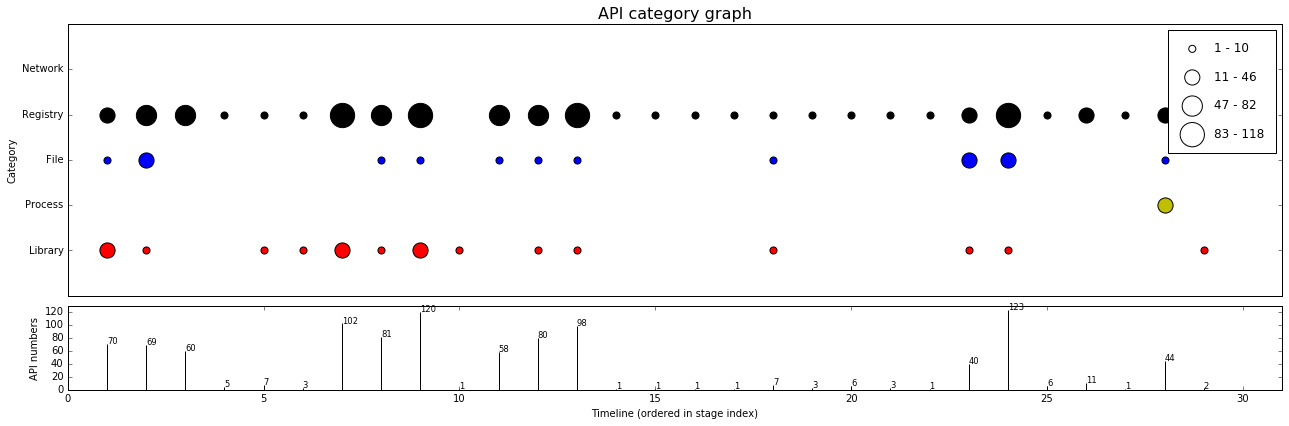

In [65]:
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(4,1,1)
ax1 = plt.subplot2grid((4,1), (0,0), rowspan=3)
plt.title('API category graph', fontsize=16)
plt.ylabel('Category')
plt.xlim(0,len(motif_dict)+2) #==========?
plt.ylim(0,6)

stage2cat_dict = {}
cat2color_dict = [['lib',1,'r'], ['pro',2,'y'], ['fil',3,'b'], ['reg',4,'k'], ['net',5,'g']]
for i, k in enumerate(sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))):
    plot_size = [0,0,0,0,0] #========== library, process, file, registry, network
    for t,a in motif_dict[k]:
        api = a[:a.index('#')]
        if len([cat for cat in type2API_dict for ain in type2API_dict[cat] if ain == api]) ==0 :
            print 'cat:',[cat for cat in type2API_dict for ain in type2API_dict[cat] if ain == api]
            print ain, api  #========== if api in category
        
        category = [cat for cat in type2API_dict for ain in type2API_dict[cat] if ain == api][0]
        
        if category == 'Library':
            plot_size[0] = plot_size[0] +1
        elif category == 'Process':
            plot_size[1] = plot_size[1] +1
        elif category == 'File':
            plot_size[2] = plot_size[2] +1
        elif category == 'Registry':
            plot_size[3] = plot_size[3] +1
        elif category == 'Network':
            plot_size[4] = plot_size[4] +1

    stage2cat_dict[i] = plot_size

stage2catMax_list=[]
for s in stage2cat_dict:
    stage2catMax_list.append(max(stage2cat_dict[s]))
if max(stage2catMax_list) >10 :scatterMax = int(round(max(stage2catMax_list)+10, -1))  #==========取到10位
else: scatterMax =max(stage2catMax_list)+10
scatterInterval= int(math.ceil(scatterMax/3))
scatterRange = range(10, scatterMax+scatterInterval ,scatterInterval)
# print scatterRange

for s in stage2cat_dict: 
    scaRanB = 0
    for scaRan in scatterRange:
        stage2cat_dict[s] = [scaRan if x < scaRan and x > scaRanB else x for x in stage2cat_dict[s] ]
        scaRanB = scaRan
    stage2cat_dict[s] = zip(stage2cat_dict[s],cat2color_dict)
for s in stage2cat_dict:
    for cat in stage2cat_dict[s]:
        plt.scatter(s+1, cat[1][1], c=cat[1][2], s=cat[0]*5, marker='o')

legendList=[]
scaRanB = 0
for ran in scatterRange:
    print scaRanB, ran
    legendList.append(plt.scatter([], [], c='w', marker='o',s=ran*5, label=str(scaRanB+1)+' - '+str(ran)))
    scaRanB =ran
plt.legend(handles=legendList,scatterpoints=1,labelspacing=1.3, borderpad=1)#,fontsize = 20) #prop={'size':20}
plt.yticks(range(1,6), ['Library', 'Process', 'File', 'Registry', 'Network'])  
plt.tick_params(#==========拿掉一些不必要的標記
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') 

#畫每stage的長度為一長條圖 
ax2 = plt.subplot2grid((4,1), (3,0))
y_Max = (max([len(motif_dict[m]) for m in sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))])+5)
if y_Max > 100: y_interval = 20
else:y_interval = 10
plt.yticks(range(0,y_Max,y_interval))

x_Max = len(motif_dict)+2
if x_Max > 10: x_interval = 5
else:x_interval = 1
plt.xticks(range(0,x_Max,x_interval))

plt.xlim(0, x_Max)
plt.ylim(0, y_Max)

plt.vlines([range(1,len(motif_dict)+1)], #==========vlines(xRange, yMinArray, yMaxArray)-> ex:([1,2], [0,0], [5,43])
           [0]*len(motif_dict), 
           [len(motif_dict[m]) for m in sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))])
for i, m in enumerate(sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))):
    plt.annotate(str(len(motif_dict[m])), xy=(i+1, len(motif_dict[m])), size='small')

#spacing
plt.xlabel('Timeline (ordered in stage index)')
plt.ylabel('API numbers')
plt.tight_layout()
# plt.savefig('data/final common motif in Firseria/Timline - category graph'+'.png', dpi=300)
plt.savefig(finalComMotif_path +'Timline - category graph'+'.png', dpi=300) #----------
print("cell 15")


In [66]:
#每個common stage都畫出一個bubble，其中有5類API，與其所使用的SC_API及其對應數量

for i, k in enumerate(sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))):
    print i, k
    g = pgv.AGraph()
    category_dict = {cat:[] for cat in type2API_dict}
    for t,a in motif_dict[k]:
        api = a[:a.index('#')]
        category = [cat for cat in type2API_dict for ain in type2API_dict[cat] if ain == api][0]
        if api in SC_API:
            if category == 'Library':
                category_dict['Library'] += [api]
            elif category == 'Process':
                category_dict['Process'] += [api]
            elif category == 'File':
                category_dict['File'] += [api]
            elif category == 'Registry':
                category_dict['Registry'] += [api]
            elif category == 'Network':
                category_dict['Network'] += [api]
    
    print 'len:', len(g.nodes())
    
    for cat in category_dict:
        if category_dict[cat] != []:
            g.add_node(len(g.nodes())+1, 
                       label=cat) #SC_API #: '+str(len(set(category_dict[cat])))+'\n')
            ddict = {}
            for a in category_dict[cat]:
                if a not in ddict:
                    ddict[a] = 1
                else:
                    ddict[a] += 1
            
            g.get_node(len(g.nodes())).attr['fillcolor'] = 'filled'
            
            if cat == 'Library':
                g.get_node(len(g.nodes())).attr['fillcolor'] = '#ff00000f'
            elif cat == 'Process':
                g.get_node(len(g.nodes())).attr['fillcolor'] = '#ffff000f'
            elif cat == 'File':
                g.get_node(len(g.nodes())).attr['fillcolor'] = '#0000ff0f'
            elif cat == 'Registry':
                g.get_node(len(g.nodes())).attr['fillcolor'] = '#00ffff0f'
            elif cat == 'Network':
                g.get_node(len(g.nodes())).attr['fillcolor'] = '#00ff000f'
            
            g.get_node(len(g.nodes())).attr['label'] = g.get_node(len(g.nodes())).attr['label'] \
                +'('+str(sum([ddict[a] for a in ddict]))+')\n'+'('+str(len(set(category_dict[cat]))) \
                +' out of '+str(len(type2SC_APIList_dict[cat]))+' SC_APIs)\n'
                    
            for a in set(category_dict[cat]):
                g.get_node(len(g.nodes())).attr['label'] = g.get_node(len(g.nodes())).attr['label'] \
                + a +': '+str(ddict[a])+'\n'
                
    for n in g.nodes():
        print g.get_node(n).attr['label']
            
    g.add_subgraph(range(1,len(g.nodes())+1), 
                   name='cluster_SC_API', 
                   style='rounded', 
                   label=k+' (API len:'+str(len(motif_dict[k]))+')')
            
#     g.draw('data/final common motif in Firseria/' +k+'.png', format='png', prog='dot')
    g.draw(finalComMotif_path +k+'.png', format='png', prog='dot')#----------
print("cell 16")

0 s1_1
len: 0
Library(24)
(1 out of 1 SC_APIs)
LoadLibrary: 24

File(1)
(1 out of 4 SC_APIs)
CreateFile: 1

Registry(1)
(1 out of 7 SC_APIs)
RegCreateKey: 1

1 s3_4
len: 0
Library(2)
(1 out of 1 SC_APIs)
LoadLibrary: 2

File(12)
(1 out of 4 SC_APIs)
CreateFile: 12

Registry(19)
(2 out of 7 SC_APIs)
RegSetValue: 13
RegCreateKey: 6

2 s5_6
len: 0
3 s7_9
len: 0
4 s9_12
len: 0
Library(2)
(1 out of 1 SC_APIs)
LoadLibrary: 2

5 s11_14
len: 0
Library(1)
(1 out of 1 SC_APIs)
LoadLibrary: 1

6 s13_16
len: 0
Library(18)
(1 out of 1 SC_APIs)
LoadLibrary: 18

Registry(2)
(1 out of 7 SC_APIs)
RegCreateKey: 2

7 s15_18
len: 0
Library(9)
(1 out of 1 SC_APIs)
LoadLibrary: 9

File(1)
(1 out of 4 SC_APIs)
CreateFile: 1

Registry(3)
(1 out of 7 SC_APIs)
RegCreateKey: 3

8 s17_20
len: 0
Library(19)
(1 out of 1 SC_APIs)
LoadLibrary: 19

File(1)
(1 out of 4 SC_APIs)
CreateFile: 1

Registry(4)
(1 out of 7 SC_APIs)
RegCreateKey: 4

9 s19_22
len: 0
Library(1)
(1 out of 1 SC_APIs)
LoadLibrary: 1

10 s21_24
len:

In [67]:
#將資源統計以表呈現
# f = open('data/final common motif in Firseria/resources in API category stat.csv', 'w')
f = open(finalComMotif_path +'resources in API category stat.csv', 'w') #----------
defchainLen_set = set()        #**********
type2defchainLen2num_dict = {} #********** 記錄每 category 中 rsc defchainLen 的分布 from defchainLen2num_dict
for cat in type2API_dict:
    defchainLen2num_dict = {}  #********** 存 1 category 中 rsc defchainLen 的分布 {1:2}-> defchainlen=1 有 2rsc 
    for rsrc in set(cat2rsrc_list[cat]):  #=========在 cat 中的 rsrc
        if len(set(var2plist_dict[rsrc])) in defchainLen2num_dict:     #========== 若 set(var2plist_dict[rsrc]) 長度
            defchainLen2num_dict[len(set(var2plist_dict[rsrc]))] += 1  #========== 已在 defchainLen2num_dict 就 +1
        else:
            defchainLen2num_dict[len(set(var2plist_dict[rsrc]))] = 1
    defchainLen_set.update(defchainLen2num_dict)
    type2defchainLen2num_dict[cat] = defchainLen2num_dict
 
print 'defchain在此資料集中有以下長度：'
print 'defchainlen:', defchainLen_set

# first row
f.write('Category,Resource #,')
for defchainLen in sorted(defchainLen_set): 
    f.write('Len='+str(defchainLen-1)+',')
f.write('\n')

# else row 
totalLen_noSameCat = 0 #=======
for cat in type2API_dict:
    dflnum_list = [type2defchainLen2num_dict[cat][dfl] for dfl in type2defchainLen2num_dict[cat]]
    print cat, dflnum_list
    f.write(cat+','+str(sum(dflnum_list))+',')
    for defchainLen in sorted(defchainLen_set):
        if defchainLen not in type2defchainLen2num_dict[cat]:
            f.write('0,')
        else:
            f.write(str(type2defchainLen2num_dict[cat][defchainLen])+',')
            if defchainLen-1 > 0:                           #=======
                totalLen_noSameCat = totalLen_noSameCat + (type2defchainLen2num_dict[cat][defchainLen]) #=======
    f.write('\n')
    
total = 0 #defchain不為零之長度個數
for var in set(var2plist_dict):
    if len(var2plist_dict[var]) >=2:
        total += 1
        
f.write('\ntotal resource,'+ str(len(var2plist_dict))+'\n')  #=======
f.write('defchainLen!=0_sameCat ,'+ str(total)+'\n')        #=======
f.write('defchainLen!=0_nosameCat ,'+ str(totalLen_noSameCat)+'\n') #=======

print 'defchain不為零之長度 (len>1)：', total #========== 包含  [(1, 4), (1, 4), (1, 4), (1, 4), (1, 4), (1, 4)]這種
print 'defchain不為零之長度no (len>1)：', totalLen_noSameCat 
print 'total resource:', len(var2plist_dict)
print("cell 18")
f.close()

defchain在此資料集中有以下長度：
defchainlen: set([1, 2, 3, 4, 6, 8, 11])
Process [2]
Network []
File [3, 9, 1]
Library [27, 8, 1, 2, 1, 1]
Registry [1, 21, 4, 5, 6]
defchain不為零之長度 (len>1)： 58
defchain不為零之長度no (len>1)： 39
total resource: 92
cell 18


In [68]:
#畫path於timeline-category graph上，幾個變數就有幾個
#選擇要輸出的Def chain圖
#input: resource
#output: Def chain path on API category graph
print var2plist_dict
var = raw_input('Input variables extracted above:')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(4,1,1)
ax1 = plt.subplot2grid((4,1), (0,0), rowspan=3)
plt.title('API category graph\n'+var, fontsize=16)
plt.ylabel('Category')
plt.xlim(0,len(motif_dict)+2)
plt.ylim(0,6)
for i, k in enumerate(sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))):
    for t,a in motif_dict[k]:
        api = a[:a.index('#')]
        category = [cat for cat in type2API_dict for ain in type2API_dict[cat] if ain == api][0]
        if category == 'Library':
            plt.plot(i+1, 1, c='r',marker='o')
        elif category == 'Process':
            plt.plot(i+1, 2, c='y',marker='o')
        elif category == 'File':
            plt.plot(i+1, 3, c='b',marker='o')
        elif category == 'Registry':
            plt.plot(i+1, 4, c='k',marker='o')
        elif category == 'Network':
            plt.plot(i+1, 5, c='g',marker='o')

plt.yticks(range(1,6), ['Library', 'Process', 'File', 'Registry', 'Network'])  
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') 
# for ii,(x,y) in enumerate(var2plist_dict[var]): #=====10/5  sorted(resFreq_dist.items(), key=lambda (k,v): v[0])
var2plist_dict[var] = sorted(var2plist_dict[var], key=lambda (k,v): k)
for ii,(x,y) in enumerate(var2plist_dict[var]):
    print ii, x, y 
    try:
#             #放大經過路徑
#             if y == 1:
#                 plt.plot(x,y,c='r',marker='o',ms=20)
#             elif y == 2:
#                 plt.plot(x,y,c='y',marker='o',ms=20)
#             elif y == 3:
#                 plt.plot(x,y,c='b',marker='o',ms=20)
#             elif y == 4:
#                 plt.plot(x,y,c='k',marker='o',ms=20)
#             elif y == 5:
#                 plt.plot(x,y,c='g',marker='o',ms=20)
        print 'sucess'
        t = FancyArrowPatch(posA=(x,y),posB=var2plist_dict[var][ii+1],
                                connectionstyle='arc3 ,rad=0.1',
                                arrowstyle='simple',
                                mutation_scale=30)
        ax1.add_patch(t)
    except:
        print 'fail'
        pass

#畫每stage的長度為一長條圖
ax2 = plt.subplot2grid((4,1), (3,0))
plt.yticks(range(0,
                max([len(motif_dict[m]) for m in sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))])+5,
                (max([len(motif_dict[m]) for m in sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))])+5)/3))
plt.xlim(0,len(motif_dict)+2)
plt.ylim(0, max([len(motif_dict[m]) for m in sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))])+5)
plt.vlines([range(1,len(motif_dict)+1)], 
           [0]*len(motif_dict), 
           [len(motif_dict[m]) for m in sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))])
for i, m in enumerate(sorted(motif_dict, key=lambda k: int(k[1:k.index('_')]))):
    plt.annotate(str(len(motif_dict[m])), xy=(i+1, len(motif_dict[m])), size='small')

#spacing

plt.xlabel('Timeline (ordered in stage index)')
plt.ylabel('API numbers')
plt.tight_layout()
# plt.savefig('data/final common motif in Firseria/Timline - category graph'+' ('+var+') '+'.png', dpi=300)
plt.savefig(finalComMotif_path + 'Timline - category graph'+' ('+var+') '+'.png', dpi=300)#----------
plt.clf()

print var + ' done!'
print 'view full graph in directory you assign!'
print("cell 17")

{'': [(24, 4), (24, 4), (24, 4), (24, 4)], 'appdata': [(12, 4)], 'oledlg.dll': [(1, 1)], 'savedlegacysettings': [(12, 4), (12, 4), (12, 4), (12, 4), (12, 4)], 'blocked': [(24, 4), (24, 4), (24, 4), (24, 4)], 'parameters': [(8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4), (8, 4)], 'cache': [(2, 4)], 'proxyoverride': [(12, 4), (12, 4)], 'ants@api.downloadmr[1].txt': [(23, 3), (23, 3), (23, 3), (23, 3), (23, 3), (23, 3), (23, 3), (23, 3), (23, 3), (23, 3), (24, 3), (24, 3), (24, 3), (24, 3), (24, 3), (24, 3), (24, 3), (24, 3), (24, 3), (24, 3)], 'advapi32.dll': [(1, 1), (1, 1), (7, 1), (1, 1)], 'ole32.dll': [(1, 1), (7, 1), (7, 1), (7, 1)], 'ws2_32.dll': [(9, 1)], 'internet settings': [(12, 4), (12, 4), (9, 4), (12, 4), (12, 4), (12, 4), (12, 4), (12, 4), (12, 4), (12, 4), (12, 4), (12, 4), (12, 4), (12, 4), (12, 4),

KeyboardInterrupt: 

In [ ]:
# #將資源統計以表呈現
# # f = open('data/final common motif in Firseria/resources in API category stat.csv', 'w')
# f = open(finalComMotif_path +'resources in API category stat.csv', 'w') #----------
# defchainLen_set = set()
# type2defchainLen2num_dict = {}
# for cat in type2API_dict:
#     defchainLen2num_dict = {}
#     for rsrc in set(cat2rsrc_list[cat]):
# #         print '\t', rsrc, len(set(var2plist_dict[rsrc]))
#         if len(set(var2plist_dict[rsrc])) in defchainLen2num_dict:
#             defchainLen2num_dict[len(set(var2plist_dict[rsrc]))] += 1
#         else:
#             defchainLen2num_dict[len(set(var2plist_dict[rsrc]))] = 1
#     defchainLen_set.update(defchainLen2num_dict)
#     type2defchainLen2num_dict[cat] = defchainLen2num_dict
 
# print 'defchain在此資料集中有以下長度：'
# print 'defchainlen:', defchainLen_set
            
# f.write('Category,Resource #,')
# for defchainLen in sorted(defchainLen_set):
#     f.write('Len='+str(defchainLen-1)+',')
# f.write('\n')
    
# for cat in type2API_dict:
#     dflnum_list = [type2defchainLen2num_dict[cat][dfl] for dfl in type2defchainLen2num_dict[cat]]
#     print cat, dflnum_list
#     f.write(cat+','+str(sum(dflnum_list))+',')
#     for defchainLen in sorted(defchainLen_set):
#         if defchainLen not in type2defchainLen2num_dict[cat]:
#             f.write('0,')
#         else:
#             f.write(str(type2defchainLen2num_dict[cat][defchainLen])+',')
#     f.write('\n')
    
# total = 0 #defchain不為零之長度個數
# for var in set(var2plist_dict):
#     if len(var2plist_dict[var]) >=2:
#         total += 1
# f.close()
# print 'defchain不為零之長度：', total
# print("cell 18")

In [ ]:
# line_up,= plt.plot([1,2,3], label='Line 2')
# line_down, = plt.plot([3,2,1], label='Line 1')
# plt.legend(handles=[line_up, line_down, line_down],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)

In [ ]:
# # print executionTrace['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog']
# # oldtt = 0
# for ii,(tt,api) in enumerate(executionTrace['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog']):
#     print ii,tt
# print executionTrace['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog'][0]

In [ ]:
# stage2ExeTrace_dict = {}
# for s, (start,end) in enumerate(stageMatrixIndex['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog']):
# #     print s+1
#     if start != -1:
#         stage2ExeTrace_dict[s+1]= executionTrace['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog'][start:end+1]
#     else:
#         stage2ExeTrace_dict[s+1]= ''
# #     print s+1, start,end
    
#     if s+1 == 5: 
#         print s+1, start,end
#         print stage2ExeTrace_dict[s+1]
    
# o = open(totalRes_path+'_ff1a_regedit2.exe.csv', 'w')
# for s,v in sorted(stage2ExeTrace_dict.items(), key=lambda (s,v): s):
#     o.write('%s\n' % (s))
#     for t,api in v:
#         if 'regedit2.exe' in api:
#             api = api.replace('\n', ' ').split('#PR#')
#             o.write(',%s,%s,%s,%s\n' % (t,api[2],api[0],api[1]))

# if o: o.close()
# # stage2ExeTrace_dict

In [ ]:
# for i, (start,end) in enumerate(stageMatrixIndex['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog']):
#     if start != -1 :
#         print i+1,',',start,',',end,',', \
#         executionTrace['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog'][start][0],',', \
#         executionTrace['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog'][end][0]
#     else:
#         print i+1,',',start,',',end
# # print executionTrace['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog'][76][0],
# # print executionTrace['ff1a143813ebc676066f76aee5e51e40_3368.trace.hooklog'][77][0]